In [0]:
import sympy
import pandas as pd
from pandas.plotting import scatter_matrix
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

In [0]:
df = pd.read_csv('Data/breast.csv')
lb = LabelEncoder() 
df['diagnosis'] = lb.fit_transform(df['diagnosis'])
df.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,1,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,1,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,1,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,1,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


In [0]:
df.columns.values

array(['id', 'diagnosis', 'radius_mean', 'texture_mean', 'perimeter_mean',
       'area_mean', 'smoothness_mean', 'compactness_mean',
       'concavity_mean', 'concave points_mean', 'symmetry_mean',
       'fractal_dimension_mean', 'radius_se', 'texture_se',
       'perimeter_se', 'area_se', 'smoothness_se', 'compactness_se',
       'concavity_se', 'concave points_se', 'symmetry_se',
       'fractal_dimension_se', 'radius_worst', 'texture_worst',
       'perimeter_worst', 'area_worst', 'smoothness_worst',
       'compactness_worst', 'concavity_worst', 'concave points_worst',
       'symmetry_worst', 'fractal_dimension_worst', 'Unnamed: 32'],
      dtype=object)

Split up into means, errors, and worsts.

In [0]:
mean_headers = ['diagnosis', 'radius_mean', 'texture_mean', 'perimeter_mean',
       'area_mean', 'smoothness_mean', 'compactness_mean',
       'concavity_mean', 'concave points_mean', 'symmetry_mean',
       'fractal_dimension_mean']
stand_err_headers = ['diagnosis', 'radius_se', 'texture_se',
       'perimeter_se', 'area_se', 'smoothness_se', 'compactness_se',
       'concavity_se', 'concave points_se', 'symmetry_se',
       'fractal_dimension_se']
worst_headers = ['diagnosis', 'radius_worst', 'texture_worst',
       'perimeter_worst', 'area_worst', 'smoothness_worst',
       'compactness_worst', 'concavity_worst', 'concave points_worst',
       'symmetry_worst', 'fractal_dimension_worst']

df_mean = df[mean_headers]
ds_err = df[stand_err_headers]
df_wor = df[worst_headers]

# Mean Data

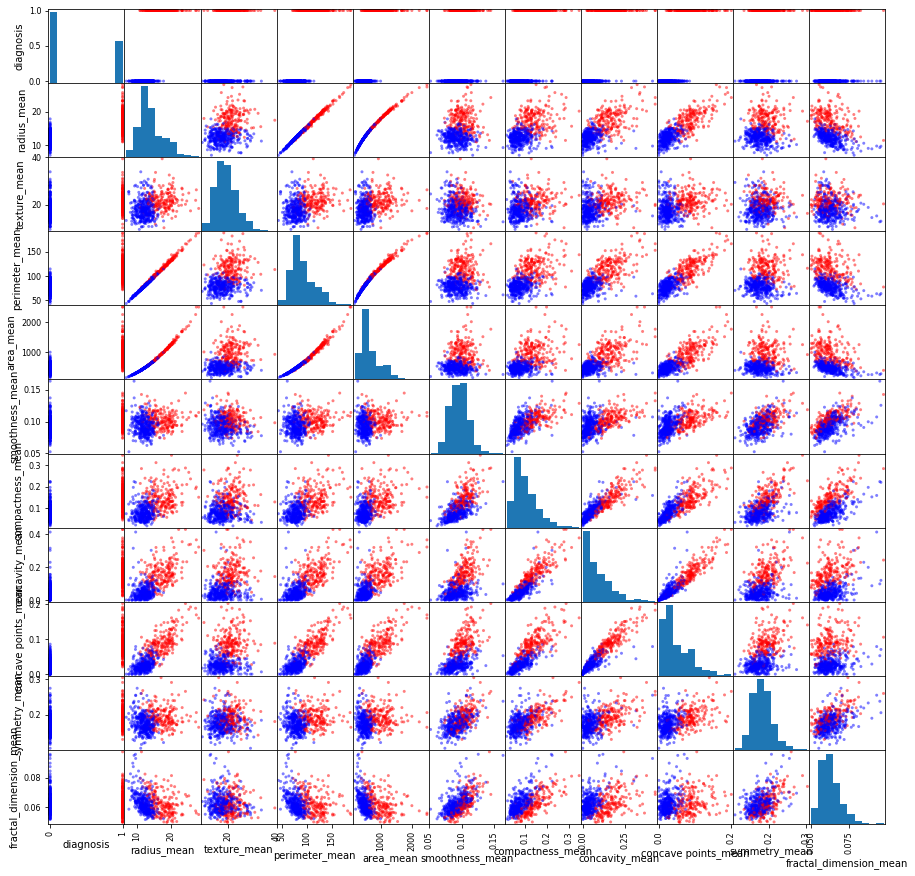

In [0]:
color_function = {0: "blue", 1: "red"} # Here Red color will be 1 which means M and blue foo 0 means B
colors = df_mean["diagnosis"].map(lambda x: color_function.get(x))# mapping the color fuction with diagnosis column
scatter_matrix(df_mean, c=colors, alpha = 0.5, figsize = (15, 15)); # plotting scatter plot matrix

In [0]:
corr = df_mean.corr()
corr.style.background_gradient(cmap='coolwarm', axis=None) # add vmin and vmax arguments in future pandas

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean
diagnosis,1,0.730029,0.415185,0.742636,0.708984,0.35856,0.596534,0.69636,0.776614,0.330499,-0.0128376
radius_mean,0.730029,1,0.323782,0.997855,0.987357,0.170581,0.506124,0.676764,0.822529,0.147741,-0.311631
texture_mean,0.415185,0.323782,1,0.329533,0.321086,-0.0233885,0.236702,0.302418,0.293464,0.071401,-0.0764372
perimeter_mean,0.742636,0.997855,0.329533,1,0.986507,0.207278,0.556936,0.716136,0.850977,0.183027,-0.261477
area_mean,0.708984,0.987357,0.321086,0.986507,1,0.177028,0.498502,0.685983,0.823269,0.151293,-0.28311
smoothness_mean,0.35856,0.170581,-0.0233885,0.207278,0.177028,1,0.659123,0.521984,0.553695,0.557775,0.584792
compactness_mean,0.596534,0.506124,0.236702,0.556936,0.498502,0.659123,1,0.883121,0.831135,0.602641,0.565369
concavity_mean,0.69636,0.676764,0.302418,0.716136,0.685983,0.521984,0.883121,1,0.921391,0.500667,0.336783
concave points_mean,0.776614,0.822529,0.293464,0.850977,0.823269,0.553695,0.831135,0.921391,1,0.462497,0.166917
symmetry_mean,0.330499,0.147741,0.071401,0.183027,0.151293,0.557775,0.602641,0.500667,0.462497,1,0.479921


Some features are bery correlated with one another. DEAL WITH THIS LATER.

## Split into train and test set

Get train and test

In [0]:
def split_train_test(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data)*test_ratio)
    
    test_indices = shuffled_indices[: test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    
    return data.iloc[train_indices], data.iloc[test_indices]

Get data and sample such that we have equal numbers of diagnosed and non-diagnosed.

In [0]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=38)
for train_index, test_index in split.split(df, df['diagnosis']): #this is only a single loop
    df_train= df_mean.loc[train_index] #train_index is an array
    df_test= df_mean.loc[test_index] # test index is an array

## Get labels

In [0]:
y_train = np.array(df_train['diagnosis'])
y_test = np.array(df_test['diagnosis'])

## Get predictors

Obtain the attributes

In [0]:
attribs = df_mean.columns.values[1::]

Import required libraries

In [0]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn import impute

Standard Scale the data, add attributes, etc..


In [0]:
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values

pipeline = Pipeline([
    ('selector', DataFrameSelector(attribs)),
    ('imputer', impute.SimpleImputer(strategy="median")),
    # ('attribs_adder', CombinedAttributesAdder()),
    ('std_scaler', StandardScaler())
])

X_train = pipeline.fit_transform(df_train)
X_test = pipeline.fit_transform(df_test)

## Train Some Models

Trained purely on raw data.

In [0]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

# Train 3 different classifiers
log_clf = LogisticRegression(solver="liblinear", random_state=42)
rnd_clf = RandomForestClassifier(n_estimators=20, max_depth=10, criterion='entropy', random_state=41)
svm_clf = SVC(gamma="auto", random_state=42, probability = True)
 
# HERE IS CODE FOR VOTING CLASSIFIER
voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='soft')

Print outcomes.

In [0]:
from sklearn.metrics import accuracy_score

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.9473684210526315
RandomForestClassifier 0.9210526315789473
SVC 0.9298245614035088
VotingClassifier 0.956140350877193


## Tune Each Model

### SVC

In [0]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import reciprocal, uniform, randint

Search over parameters.

In [0]:
%%capture
param_distributions = {"gamma": reciprocal(0.001, 0.2), "C": uniform(0, 45)}
SVC_search_cv = RandomizedSearchCV(SVC(probability = True), param_distributions, n_iter=100, verbose=2, cv=10, random_state=42)
SVC_search_cv.fit(X_train, y_train)

Get results.

In [0]:
results = SVC_search_cv.cv_results_

Cs = np.array(results['param_C'], dtype=float)
gammas = np.array(results['param_gamma'], dtype=float)
scores = np.array(results['mean_test_score'], dtype=float)

Plot which are best

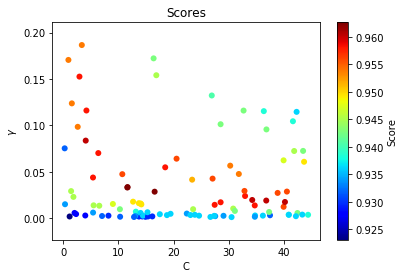

In [0]:
plt.scatter(Cs, gammas, c=scores, cmap="jet", lw=0)
plt.xlabel('C')
plt.ylabel(r'$\gamma$')
plt.colorbar(label='Score')
plt.title('Scores')
plt.show()

In [0]:
y_pred = SVC_search_cv.predict(X_test)
accuracy_score(y_test, y_pred)

0.9473684210526315

Get best model

In [0]:
SVC_clf_new = SVC_search_cv.best_estimator_

### Random Forest

Search over parameters.

In [0]:
%%capture
criterion = {1: 'gini', 2:'entropy'}
param_distributions = {"max_depth": randint(4, 20),
                       "n_estimators": randint(10, 40),
                       "criterion": ['gini', 'entropy']}

rnd_search_cv = RandomizedSearchCV(RandomForestClassifier(), param_distributions, n_iter=100,
                                   verbose=2, cv=5, random_state=42)
rnd_search_cv.fit(X_train, y_train)

Get results

In [0]:
results = rnd_search_cv.cv_results_

n_estimators = np.array(results['param_n_estimators'], dtype=float)
criterion = np.array(results['param_criterion'])
max_depths = np.array(results['param_max_depth'], dtype=float)
scores = np.array(results['mean_test_score'], dtype=float)


Plot which are best

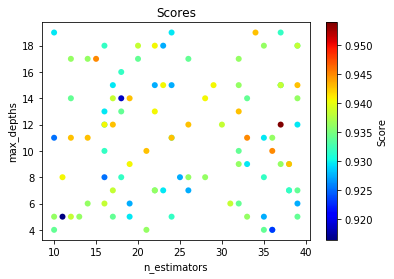

In [0]:
plt.scatter(n_estimators, max_depths, c=scores, cmap="jet", lw=0)
plt.xlabel('n_estimators')
plt.ylabel(r'max_depths')
plt.colorbar(label='Score')
plt.title('Scores')
plt.show()

Print scores

In [0]:
y_pred = rnd_search_cv.predict(X_test)
accuracy_score(y_test, y_pred)

0.9385964912280702

Get best model

In [0]:
rnd_clf_new = rnd_search_cv.best_estimator_

## Check Voting Classifier Again

In [0]:
voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf_new), ('svc', SVC_clf_new)],
    voting='soft')
voting_clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

VotingClassifier 0.956140350877193
